# Eccentric Search Prospects for Cosmic Explorer

## Amber Lenon<sup>1</sup>, Alexander Nitz<sup>2,3</sup>, Duncan Brown<sup>1</sup>

**<sup>1</sup> Department of Physics, Syracuse University, Syracuse NY 13224, USA** <br />
**<sup>2</sup> Max-Planck-Institut für Gravitationsphysik, Albert-Einstein-Institut, D-30167 Hannover, Germany** <br />
**<sup>3</sup> Leibniz Universität Hannover, D-30167 Hannover, Germany**

We want to explore how sensitive a search for gravitational waves with circular templates will be for eccentric searches in third generation detectors, specifically [Cosmic Explorer](https://cosmicexplorer.org/) (referenced as CE). Cosmic Explorer will be more sensitive with arms longer 10x longer than that of LIGO. Currently for LIGO circular searches are effective for eccentricities below 0.05, but that might not be the case for Cosmic Explorer. To evaluate the search sensitivity, we first determine how long the templates need to be to capture almost all of the available signal-to-noise ratio (SNR) in Cosmic Explorer. The length of a template is determined by its low-frequency cutoff, so we investigate the frequency needed to get at least 99% of the SNR. We then investigate how quickly the signal-to-noise ratio decreases for a single template to determine a reasonable eccentricity cutoff for our simulated signals. Using a template bank containing gravitational waveforms for circular binaries at the appropriate low-frequency cutoff (generated using an external program), we create a large set of simulated eccentric signals and determine the ability of the bank to detect them. I find that for eccentricities $<0.01$ the circular template bank can detect the simulated eccentric signal 100% of the time. For eccentricities $>0.025$ the circular template bank fails at detecting the simulated eccentric signal 100% of the time.

<img src="combine_eccen.gif" alt="Circular vs Eccentric" width="75%"/>

### Set Imports and plot format

In [1]:
#PyCBC imports
import pycbc
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import match
from pycbc.types import FrequencySeries
from pycbc import distributions
import pycbc.psd
from pycbc.filter import match, sigmasq
import pycbc.conversions as conversions

#specific imports
import gc
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import argparse
import sys, os
import pandas as pd

/work/amber.lenon/projects/eccen/pycbc-ecc-search/local/lib/python2.7/site-packages/OpenSSL/_util.py:6: CryptographyDeprecationWarning: Python 2 is no longer supported by the Python core team. Support for it is now deprecated in cryptography, and will be removed in a future release.
  from cryptography.hazmat.bindings.openssl.binding import Binding


In [2]:
rcParams['figure.figsize']=(14,8)
rcParams['axes.grid']=True
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

## Calculate Appropriate Low Frequency Cutoff for Waveform

First I evaluate the appropriate low frequency cutoff to generate the template bank and for the generation of simulated waveforms. I calculate how much signal-to-noise ratio I accumulate as a function of low-frequency cutoff (i.e. template length) and determine the point at which I have accumulated at least 99.9% of the signal-to-noise ratio. There are two phases of the Cosmic Explorer design (CE1 and CE2) so I calculate this for each detector.

### Set data segment length

In [3]:
td_length = 2048            # length of each segment in seconds
srate = 4096                # sample rate of the segment in Hz
N = int(td_length * srate)  # number of samples
fd_length = int(N / 2 + 1)  # length of each segment in 
delta_t = 1.0 / srate       # time between samples in seconds
delta_f = 1.0 / td_length   # frequency between consecutive samples in Hz

### Read in the Detector Sensitivity Files

In [4]:
CE1_sensitivity = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/noise-files/CE1_strain.txt'
CE2_sensitivity = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/noise-files/CE2_strain.txt'

#Import the amplitude spectral density file
psd_ce1 = pycbc.psd.from_txt(CE1_sensitivity,
                             length=fd_length, delta_f=delta_f,
                             low_freq_cutoff=3.0, is_asd_file=True)
psd_ce2 = pycbc.psd.from_txt(CE2_sensitivity, 
                             length=fd_length, delta_f=delta_f, 
                             low_freq_cutoff=3.0, is_asd_file=True)

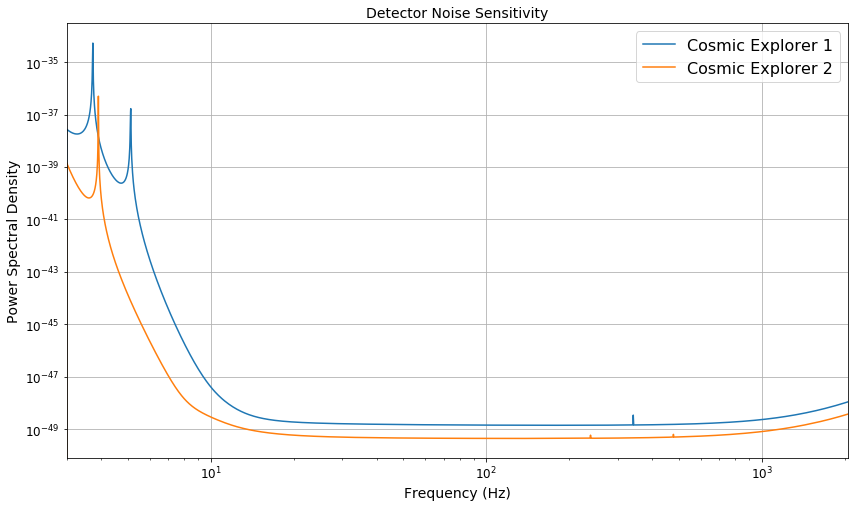

In [5]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.loglog(psd_ce1.sample_frequencies, psd_ce1, label = "Cosmic Explorer 1")
plt.plot(psd_ce2.sample_frequencies, psd_ce2, label = "Cosmic Explorer 2")
plt.legend(fontsize = 16)
plt.xlim([3,2048])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Detector Noise Sensitivity")
plt.show()

###  Calculate Appropriate Low Frequency Cutoff for Waveform

To calculate the cumulative signal-to-noise ratio as a function of low frequency cutoff, we use the integrand of the signal-to-noise ratio given by $\frac{\tilde{h}(f)\tilde{h}^\ast(f)}{S_n(f)}$. This is integrated from a fixed upper frequency cutoff to a variable low frequency cutoff.

We then compute the normalized signal-to-noise ratio for each detector at the minimum low-frequency cutoff (3 Hz), equivalent to setting the signal-to-noise ratio of the source unity in each detector, so that we can compute the fraction of SNR lost. 

We flip the frequencies so we are able to plot them from highest frequency on the left to the lowest frequency on the right.

In [6]:
def cumulative_snr(psd, f_low, fd_length, delta_f):
    
    m1 = m2 = 1.4

    #Generate a circular waveform
    sp_tilde, sc_tilde = pycbc.waveform.get_fd_waveform(approximant="TaylorF2", 
                                                    mass1=m1, mass2=m1, delta_f=delta_f, f_lower=3.0)
    #Resize the waveform
    sp_tilde.resize(fd_length)
    
    #Calculate multiply the waveform and complex conjugate
    sp_sp_ast = np.absolute(sp_tilde.conj()*sp_tilde)

    #Evaluate the integrand of the signal-to-noise ratio
    snr_integrand = sp_sp_ast / psd

    #Calculate the index of the low-frequency cutoff and round up
    f_low_idx = int(f_low / snr_integrand.delta_f + 1)
    
    #calculate the normalization constant from the snr integrand
    normalization_constant = np.trapz(snr_integrand[f_low_idx:], 
                        snr_integrand.sample_frequencies[f_low_idx:])
        
    #normalize the snr integrand
    normalized_snr_integrand = snr_integrand/normalization_constant
        
    #calculate the cumulative snr
    cumulative_snr = np.cumsum(np.flipud(
            normalized_snr_integrand[f_low_idx:]))/(fd_length*delta_f)
        
    #flip the array so that higher frequencies are on the left
    flip =  np.flipud(snr_integrand.sample_frequencies[f_low_idx:])    
    
    #calculate the index where the flip is less than 7Hz
    idx = np.where(flip<7.0)[0][0]
    
    return cumulative_snr, flip, idx

In [7]:
cumulative_snr_ce1, flip_ce1, seven_idx_ce1 = cumulative_snr(psd_ce1, 3.0, fd_length, delta_f)
cumulative_snr_ce2, flip_ce2, seven_idx_ce2 = cumulative_snr(psd_ce2, 3.0, fd_length, delta_f)

/work/amber.lenon/projects/eccen/pycbc-ecc-search/local/lib/python2.7/site-packages/PyCBC-1f5ebd-py2.7-linux-x86_64.egg/pycbc/types/array.py:368: RuntimeWarning: invalid value encountered in true_divide
  return self._data / other


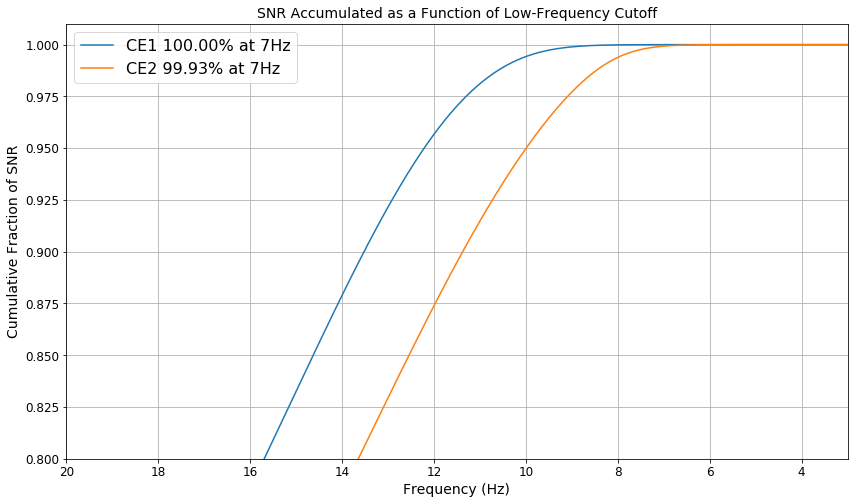

In [8]:
gc.collect()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(flip_ce1, cumulative_snr_ce1, label = "CE1 {snr_frac:.2f}% at 7Hz".format(
    snr_frac=cumulative_snr_ce1[seven_idx_ce1]*100.0))
plt.plot(flip_ce2, cumulative_snr_ce2, label = "CE2 {snr_frac:.2f}% at 7Hz".format(
    snr_frac=cumulative_snr_ce2[seven_idx_ce2]*100.0))
plt.legend(fontsize=16)
plt.xlim([20,3])
plt.ylim([0.80,1.01])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Cumulative Fraction of SNR")
plt.title("SNR Accumulated as a Function of Low-Frequency Cutoff")
gc.collect()
plt.show()

In the above plot we can see that both Cosmic Explorer 1 and Cosmic Explorer 2 have accumulated more than 99% of the total signal-to-noise ratio by 7Hz. Because waveforms at higher frequency are shorter, we need to go to lower frequencies to get longer waveforms to accumulate more than 99% of the total signal-to-noise ratio.

## Calculate the Overlap for Waveforms with Varying Eccentricity

We want to evaluate how quickly the overlap of an circular waveform falls off when compared to an eccentric waveform with the same parameters, but with varying eccenticity. To do this we calclulate the overlap between a circular waveform and an eccentric waveform for eccentricities between $0-0.4$. Now that we know that we have more than 99% of the total signal-to-noise ratio by 7Hz, we can set f_low to 7Hz the rest of the codes.

In [9]:
f_low = 7.0     # starting frequency of the waveform

eccen_range = np.arange(0.0,0.4001,0.001)   # Eccentricity range to investigate
CE1_overlap = np.zeros(len(eccen_range))    # Array the length of eccen
CE2_overlap = np.zeros(len(eccen_range))

In [10]:
psd_ce1 = pycbc.psd.from_txt(CE1_sensitivity,
                             length=fd_length, delta_f=delta_f,
                             low_freq_cutoff=f_low, is_asd_file=True)

hp, _ = get_fd_waveform(approximant="TaylorF2", mass1=1.4, mass2=1.4,
                         f_lower=f_low, f_ref = 10.0, delta_f=delta_f)
hp.resize(fd_length)

idx = 0
for ecc in eccen_range:
    
    sp, _ = get_fd_waveform(approximant="TaylorF2Ecc", mass1=1.4, mass2=1.4,
                         f_lower=f_low, f_ref = 10.0, delta_f=delta_f, eccentricity = ecc)
    sp.resize(fd_length)
    
    CE1_overlap[idx], _ = match(hp, sp, psd=psd_ce1, low_frequency_cutoff=f_low)
    CE2_overlap[idx], _ = match(hp, sp, psd=psd_ce2, low_frequency_cutoff=f_low)
    
    idx+=1

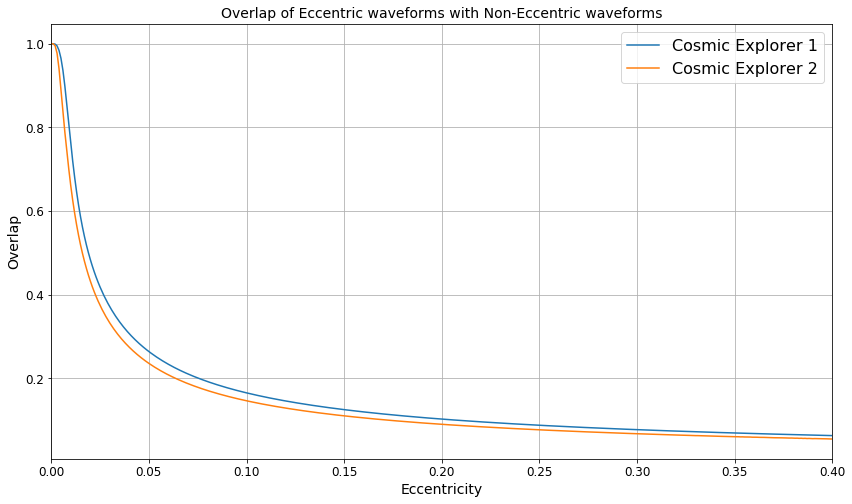

In [11]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(eccen_range, CE1_overlap, label = "Cosmic Explorer 1")
plt.plot(eccen_range, CE2_overlap, label = "Cosmic Explorer 2")
plt.legend(fontsize = 16)
plt.xlim(0,0.4)
plt.xlabel("Eccentricity")
plt.ylabel("Overlap")
plt.title("Overlap of Eccentric waveforms with Non-Eccentric waveforms")
plt.show()

In the above plot we can see that the overlap for Cosmic Explorer falls off quickly. We see an overlap $\sim 0.2$ for eccentricities $<0.05$ This means that we can inject waveforms into the template bank with eccentricities between $0.0 - 0.05$

## Injection of Eccentric Waveform into Circular Template Bank

To evaluate the sensitivitiy, we generate a waveform with random masses and eccentricity and compare that with waveforms from the template bank. Since the Cosmic Explorer 1 template bank has $\sim130000$ templates and each injection takes between 20 mins to 1.5 hours to get through the full template bank the script is too large to run using jupyter. It is submitted to a computing cluster to run quickly and in parallel.

In [12]:
CE1_template_bank_file = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/banksim/banks/nonecc/CE1/NonSpin-7Hz-m1m2-CE1.txt'
template_bank = np.loadtxt(CE1_template_bank_file ,delimiter =',')
bank_mass_1 = template_bank[:,0]
bank_mass_2 = template_bank[:,1]

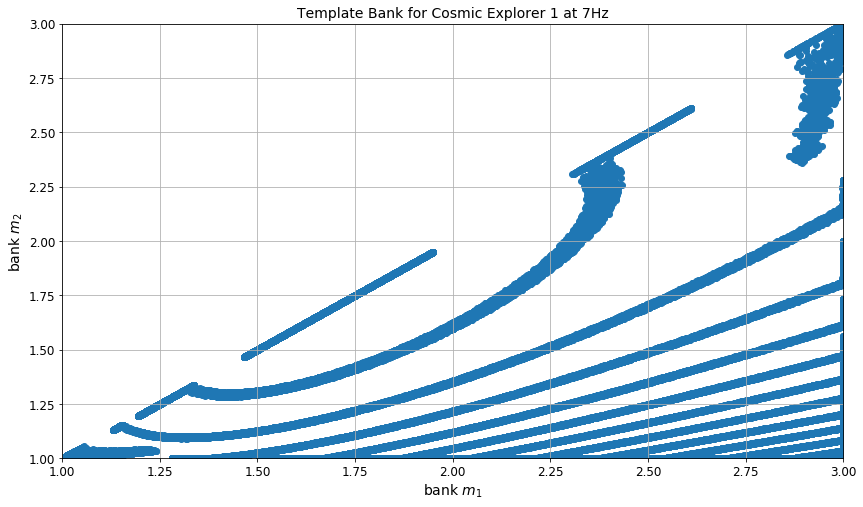

In [13]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(bank_mass_1, bank_mass_2)
plt.xlim(1.0,3.0)
plt.ylim(1.0,3.0)
plt.xlabel(r'bank $m_1$')
plt.ylabel(r'bank $m_2$')
plt.title('Template Bank for Cosmic Explorer 1 at 7Hz')
plt.show()

### Simulation of Template Bank -- Python Script

`np.random.seed(seed=None)` uses `/dev/urandom` to generate single random number to seed the random number generator

```python

#Set seed for random number generator
np.random.seed(seed=None)   

#Import the sensitivity curve
CE1_sensitivity = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/noise-files/CE1_strain.txt'
psd_ce1 = pycbc.psd.from_txt(CE1_sensitivity,
                             length=fd_length, delta_f=delta_f,
                             low_freq_cutoff=7.0, is_asd_file=True)

# Read in Template Bank Files
CE1_template_bank_file = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/banksim/banks/nonecc/CE1/NonSpin-7Hz-m1m2-CE1.txt'
template_bank = np.loadtxt(CE1_template_bank_file ,delimiter =',')
bank_mass_1 = template_bank[:,0]
bank_mass_2 = template_bank[:,1]

while True:

    #Generate random m1, m2, and ecc value within given range
    #Masses from 1.0 to 3.0--BNS
    #ecc from 0 to 0.05
    injection_m1 = distributions.uniform.Uniform(s=(1.0, 3.0)).rvs(1)["s"] 
    injection_m2 = distributions.uniform.Uniform(s=(1.0, 3.0)).rvs(1)["s"]
    injection_ecc = distributions.uniform.Uniform(s=(0.0, 0.05)).rvs(1)["s"]
    
    #Calculate a waveform with the generated masses
    injection_waveform_plus, _ = get_fd_waveform(approximant="TaylorF2Ecc", mass1=injection_m1,
                                              mass2=injection_m2,
                                              delta_f=delta_f,
                                              f_lower=f_low, eccentricity=injection_ecc)
    #Calculate the tau0 of the injected waveform
    injection_tau0 = conversions.tau0_from_mass1_mass2(injection_m1, injection_m2, f_lower=15)
	
	#Reset the maximum match for this injection
	max_match = 0
	
    for tidx in range(len(bank_mass_1)):
		
		template_m1 = bank_mass_1[tidx]
		template_m2 = bank_mass_2[tidx]
		
        #Calculate the tau0 of the template waveform
        template_tau0 = conversions.tau0_from_mass1_mass2(template_m1, template_m2, f_lower=15)
        #Take absolute value of difference between the 2 tau0 values
        delta_tau0 = np.abs(template_tau0-injection_tau0)

        #Only enter if difference is less than 3.0
        if delta_tau0 < 3.0:
            
                #Calculate a waveform with template parameters
                template_waveform_plus, __ = get_fd_waveform(approximant = "TaylorF2", mass1 = template_m1, 
                                                 mass2 = template_m2,  
                                                 f_lower=f_low, delta_f=delta_f)
                
                flen = min(len(injection_waveform_plus), len(template_waveform_plus), len(psd_ce1))
                injection_waveform_plus.resize(flen)
                template_waveform_plus.resize(flen)
                
                match_ce1, _ = match(injection_waveform_plus, template_waveform_plus, 
                                     psd = psd_ce1, low_frequency_cutoff = f_low)
                
           #If the match for this template exceeds the stored max, update the max
            if match_ce1 > max_match:
                max_match = match_ce1
                max_match_template_m1 = template_m1
                max_match_template_m2 = template_m2

    #Print out the maximum match across the template bank for this injection
    print injection_m1[0], injection_m2[0], injection_ecc[0], max_match_template_m1, max_match_template_m2, max_match
    sys.stdout.flush()
```

### Condor Submit File

```bash
universe = vanilla
executable = /work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/banksim/CE1-banksim/noneccen/CE1_banksim
getenv = True
request_memory =  20 Gb

output = logs/job-CE1-banksim.$(cluster).$(process).out
error = logs/job-CE1-banksim.$(cluster).$(process).err
log =  logs/job-CE1-banksim.$(cluster).log

stream_error = True
stream_output = True
accounting_group=aei.dev.cbc

queue 1000
```

## Plot Results from the Simulation

### Read in the Injection Match File

In [14]:
injection_match_file = '/work/amber.lenon/projects/eccen/3G-search-prospects/eccentric-search-prospects/banks/banksim/CE1-banksim/noneccen/CE1-injection-7Hz.txt'
simulation_data = pd.read_csv(injection_match_file, sep=" ", header=None)
simulation_data.columns = ["injection_mass1", "injection_mass2", "eccentricity", "template_mass1", "template_mass2", "overlap"]
eccentricity = simulation_data['eccentricity']
overlap = simulation_data['overlap']

### Plot the Eccentricity vs. Fitting Factor

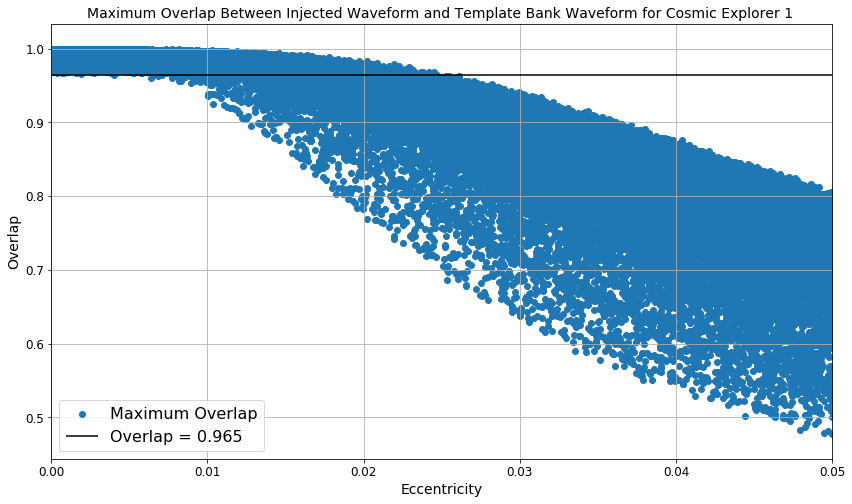

In [15]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(eccentricity,overlap, label = 'Maximum Overlap')
plt.hlines(0.965,0,0.05, label = "Overlap = 0.965")
plt.xlim(0,0.05)
plt.legend(fontsize = 16, loc = 'lower left')
plt.xlabel("Eccentricity")
plt.ylabel("Overlap")
plt.title("Maximum Overlap Between Injected Waveform and Template Bank Waveform for Cosmic Explorer 1 ")
plt.show()

In the above plot, we show the overlap between the injected waveform and template bank waveform as a function of eccentricity. As we get to higher eccentricities, we can see that the maximum overlap decreases. Based on previous work done, an eccentricity below 0.05 can be found by searches that use circular templates. However, for Cosmic explorer the overlap 100% works for eccentricity $<0.01$ and starts to completely fail at eccentricity $>0.025$. This implies that a circular search might not be effectual at detecting eccentric searches in Cosmic Explorer.